In [0]:
# Importing required packages
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.io as sio
import itertools
import operator
import random
import collections
from scipy import stats
from sklearn.metrics import accuracy_score

In [0]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict

data - a 10,000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.

labels - a list of 10,000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data.


Visualization

In [0]:
def get_data(file):
    dict = unpickle(file)
    X = np.asarray(dict['data']).astype("uint8")
    Y = np.asarray(dict['labels'])
    names = np.asarray(dict['filenames'])
    list_class=(unpickle("AIML_DS_CIFAR-10_STD/batches.meta")['label_names'])
    return X,Y,names,list_class
                     
def visualize_image(X, Y, names, image_id):
    rgb = X[image_id,:]
    img = rgb.reshape(3, 32, 32).transpose([1, 2, 0])
    print(img.shape)
    plt.grid(False)
    plt.imshow(img)
    plt.title(names[image_id])
    plt.show()

Class = horse
(32, 32, 3)


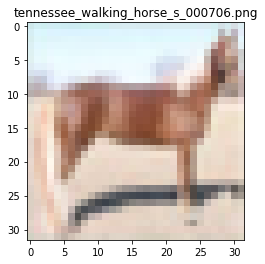

In [0]:
X, Y, names, classes = get_data("AIML_DS_CIFAR-10_STD/data_batch_3")
pick = 10
print("Class =",classes[Y[pick]])
visualize_image(X, Y, names, pick)

In [0]:
## Linear classifier
# function to estimate optimal linear boundary
# classify train data by estimating the optimal linear boundary
# predict labels based on linear boundary
# and compute the accuracy of the classification

def perceptron_sgd(X, Y):
    w = np.zeros(len(X[0]))
    eta = 0.01 # learning rate
    epochs = 100
    for t in range(epochs):
        if (t+1) % 50 == 0:
            print("Running Epoch #", t+1)
            print("acc:", compute_accuracy(predict(X[:, :-1], w), Y))
        for i, x in enumerate(X):
            if (np.dot(X[i], w) * Y[i]) <= 0:
                w = w + eta*X[i]*Y[i] #updating weights by multiplying eta
        eta *= 0.75 #decreasing eta after every epoch
    return w


In [0]:
# classify train data by estimating the optimal linear boundary,
def classify(train_feat, train_labels):
    ## mapping first label to -1 and second to +1
    labels = np.sort(np.unique(train_labels))
    lmap = {labels[0] : -1, labels[1] : 1}
    l = [lmap[i] for i in train_labels]     
    ## appending 1 to train features
    add_one2train = np.ones((len(train_feat), 1))
    append_train_features = np.hstack((np.asarray(train_feat), add_one2train))
    w = perceptron_sgd(append_train_features, l)
    return w

In [0]:
# predict labels based on linear boundary,
def predict(features, w):
    ##appending 1 to test features
    add_one = np.ones((len(features),1))
    append_features = np.hstack((np.asarray(features), add_one))
    pred = np.dot(append_features, w)
    return pred

In [0]:
# compute the accuracy of the classification
def compute_accuracy(pred, test_labels):
    # To make it general, let us find the unique set of labels in test_labels
    labels = np.sort(np.unique(test_labels))
    # and then assign -1 and 1 to these unique labels
    lmap = {labels[0] : -1, labels[1] : 1}
    # Let's now convert the labels to -1 and 1
    l = [lmap[i] for i in test_labels]
    # Let us find the accuracy
    p = []
    for i in range(len(pred)):
        p.append(1 if pred[i] >= 0 else -1)
    acc = np.mean(np.asarray(p) == np.asarray(l))
    return acc

In [0]:
# Function for binary classification
def one_vs_one_classifier_ours(train_features, train_labels):
    w = classify(train_features, train_labels)
    return w

def calc_accuracy(X_test, Y_test, w):
    pred = predict(X_test, w)
    accuracy = compute_accuracy(pred, Y_test)
    print("accuracy =", accuracy)

Feature 1: RGB values

In [0]:
X_train = []
Y_train = []
# Read all training features and labels
for j in "12345": 
    batch_file = 'AIML_DS_CIFAR-10_STD/data_batch_'+ j
    x_train, y_train, names_train, classes_train = get_data(batch_file)
    X_train.extend(x_train)
    Y_train.extend(y_train)

X_train = np.asarray(X_train)
Y_train = np.asarray(Y_train)

# Read all test features and labels
X_test, Y_test, names_test, classes_test = get_data("AIML_DS_CIFAR-10_STD/test_batch")

In [0]:
len(np.concatenate([X_train[Y_train == 5], X_train[Y_train == 7]]))

10000

In [0]:
type(X_train[Y_train == 7])

numpy.ndarray

In [0]:
# Function to extract the classes
def extract_2classes(class0, class1, X, Y):
    # Select class #0
    X_0 = X[Y == class0]
    Y_0 = Y[Y == class0]
    # Select class #1
    X_1 = X[Y == class1]
    Y_1 = Y[Y == class1]
    # Join the two classes to make the set
    X_2classes = np.concatenate((X_0,X_1))
    Y_2classes = np.concatenate([Y_0,Y_1])
    return X_2classes, Y_2classes

In [0]:
# Select classes #5 and #7
X_train_2classes, Y_train_2classes = extract_2classes(5, 7, X_train, Y_train)
X_test_2classes, Y_test_2classes = extract_2classes(5, 7, X_test, Y_test)#YOUR CODE HERE

In [0]:
# Binary classification for classes 1 and 2
w = one_vs_one_classifier_ours(X_train_2classes, Y_train_2classes)

# Find accuracy
calc_accuracy(X_test_2classes, Y_test_2classes, w)

Running Epoch # 50
acc: 0.6486
Running Epoch # 100
acc: 0.6495
accuracy = 0.644


Feature 2: PCA

In [0]:
## apply pca
from sklearn.decomposition import PCA

def extract_eigenvectors(k, X_train):
    pca = PCA(n_components=k)
    pca.fit(X_train)
    eigen_vectors = pca.components_
    return eigen_vectors, pca

def make_pca_features(eigen_vectors, X):
    return np.dot(X,np.transpose(eigen_vectors))#Dot product of Eigen Vectors and X)

In [0]:
# Make pca features
k = 200
eigen_vectors, pca_object = extract_eigenvectors(k, X_train_2classes)
pca_features_train_2classes = make_pca_features(eigen_vectors, X_train_2classes)
pca_features_test_2classes = make_pca_features(eigen_vectors, X_test_2classes)

In [0]:
len(eigen_vectors[:][0])

3072

In [0]:
pca_features_train_2classes.shape

(10000, 200)

In [0]:
# Binary classification for classes 1 and 2 
w = one_vs_one_classifier_ours(pca_features_train_2classes, Y_train_2classes)

# Find accuracy
calc_accuracy(pca_features_test_2classes, Y_test_2classes, w)

Running Epoch # 50
acc: 0.6451
Running Epoch # 100
acc: 0.6465
accuracy = 0.6365


In [0]:
for k in [800, 1000, 1200, 1400]:
    print("Training with k =", k)
    # Make pca features
    eigen_vectors, pca_object = extract_eigenvectors(k, X_train_2classes)
    pca_features_train = make_pca_features(eigen_vectors, X_train_2classes)
    pca_features_test = make_pca_features(eigen_vectors, X_test_2classes)
    # Binary classification for classes 1 and 2 
    w = one_vs_one_classifier_ours(pca_features_train, Y_train_2classes)
    # Find accuracy
    calc_accuracy(pca_features_test, Y_test_2classes, w)

Training with k = 800
Running Epoch # 50
acc: 0.6512
Running Epoch # 100
acc: 0.651
accuracy = 0.645
Training with k = 1000
Running Epoch # 50
acc: 0.6482
Running Epoch # 100
acc: 0.6497
accuracy = 0.644
Training with k = 1200
Running Epoch # 50
acc: 0.6501
Running Epoch # 100
acc: 0.6498
accuracy = 0.6445
Training with k = 1400
Running Epoch # 50
acc: 0.6488
Running Epoch # 100
acc: 0.6494
accuracy = 0.644


Feature 3: Deep features

In [0]:
### Loading the features
features = sio.loadmat('AIML_DS_CIFAR-10_STD/cifar10_deep_features.mat')

In [0]:
# Extracting the deep features into training and testing
deep_features_train = features['x_train']
deep_labels_train = np.squeeze(np.transpose(features['y_train']))
deep_features_test = features['x_test']
deep_labels_test = np.squeeze(np.transpose(features['y_test']))
print(deep_features_train.shape, deep_labels_train.shape, deep_features_test.shape, deep_labels_test.shape)

(50000, 512) (50000,) (10000, 512) (10000,)


In [0]:
deep_features_train[deep_labels_train == 1]

array([[ 0.28628892,  1.5803168 ,  1.6731801 , ...,  0.10207038,
         1.6519655 ,  0.03424041],
       [ 0.0078609 ,  1.6982508 ,  1.7098854 , ...,  0.01749726,
         1.670898  ,  0.01227446],
       [ 0.00415532,  1.6800256 ,  1.724329  , ...,  0.08949629,
         1.655726  , -0.06013504],
       ...,
       [ 0.11069122,  1.7514377 ,  1.7425244 , ..., -0.06992859,
         1.8052185 ,  0.19582546],
       [ 0.07522582,  1.7225255 ,  1.6861435 , ...,  0.04768213,
         1.657213  ,  0.07425953],
       [ 0.50009876,  1.2441009 ,  1.6093069 , ...,  0.6612573 ,
         1.4234178 , -0.44916058]], dtype=float32)

In [0]:
# Extract features of class0 and class1
deep_features_train_2classes, deep_labels_train_2classes = extract_2classes(5,7,deep_features_train,deep_labels_train)
deep_features_test_2classes, deep_labels_test_2classes = extract_2classes(5,7,deep_features_test,deep_labels_test)

In [0]:
# Binary classification for classes 1 and 2 
w = one_vs_one_classifier_ours(deep_features_train_2classes, deep_labels_train_2classes)

# Find accuracy
calc_accuracy(deep_features_test_2classes, deep_labels_test_2classes, w)

Running Epoch # 50
acc: 1.0
Running Epoch # 100
acc: 1.0
accuracy = 0.9795
